# Punteggio totale e modello fattoriale {#sec-fa-model-1}

In [4]:
source("../../code/_common.R")
suppressPackageStartupMessages({
    library("psych")
    library("lavaan")
    library("modelsummary") # for summarizing data
})

In questo capitolo discute l'uso del punteggio totale del test quale misura del costrutto latente. Questa è una pratica largamente usata, ma solo in parte giustificata. Esamineremo a questo proposito le considerazioni di McNeish e Wolf (2020).

## Punteggio totale e modello fattoriale parallelo

McNeish e Wolf (2020) richiamano l'attenzione sul fatto che usare il punteggio totale quale misura di un costrutto è possibile solo quando i dati soddisfano i vincoli di un modello fattoriale parallelo.

Consideriamo l'esempio seguente, nel quale McNeish e Wolf (2020) esaminano i dati "classici" di Holzinger and Swineford (1939), i quali si riferiscono ai seguenti item:

- Paragraph comprehension
- Sentence completion
- Word definitions
- Speeded addition
- Speeded dot counting
- Discrimination between curved and straight letters

Leggiamo i dati in R.

In [5]:
d <- rio::import(
  "../data/1_Factor_Parallel.csv"
)

McNeish e Wolf (2020) sottolineano il fatto che il punteggio totale 

$$
\text{Punteggio totale} = \text{Item 1 + Item 2 + Item 3 + Item 4 + Item 5 + Item 6}
$$

rappresenta l'idea che ciasun item fornisca la stessa quantità di informazione relativamente alla misura del costrutto. Ciò può essere specificato da un modello fattoriale nel quale le saturazioni fattoriali degli item sono tutte uguali a 1. Questo corrisponde al modello parallelo che abbiamo discusso in precedenza. In tali circostanze, i punteggi fattoriali del test risultano perfettamente associati al punteggio totale (correlazione uguale a 1). Dunque, se tale modello fattoriale è giustificato dai dati, questo giustifica l'uso del punteggio totale del test quale misura del costrutto.

È facile verificare tali affermazioni.  Implementiamo il modello parallelo.

In [6]:
m_parallel <-
  "
  # all loadings are fixed to one
  f1 =~ 1*X4 + 1*X5 + 1*X6 + 1*X7 + 1*X8 + 1*X9
  
  # all residual variances constrained to same value
  X4 ~~ theta*X4
  X5 ~~ theta*X5
  X6 ~~ theta*X6
  X7 ~~ theta*X7
  X8 ~~ theta*X8
  X9 ~~ theta*X9
"

Adattiamo il modello parallelo ai dati forniti dagli autori.

In [7]:
fit_parallel <- sem(m_parallel, data=d)

Calcoliamo il punteggio totale.

In [8]:
d$ts <- with(
  d,
  X4 + X5 + X6 + X7 + X8 + X9
)

Calcoliamo i punteggi fattoriali.

In [9]:
scores <- lavPredict(fit_parallel, method="regression")
d$scores <- as.numeric(scores)

Un diagramma a dispersione tra il punteggio totale e i punteggi fattoriali conferma che i due sono perfettamente associati. Quindi, usare il punteggio totale o i punteggi fattoriali è equivalente.

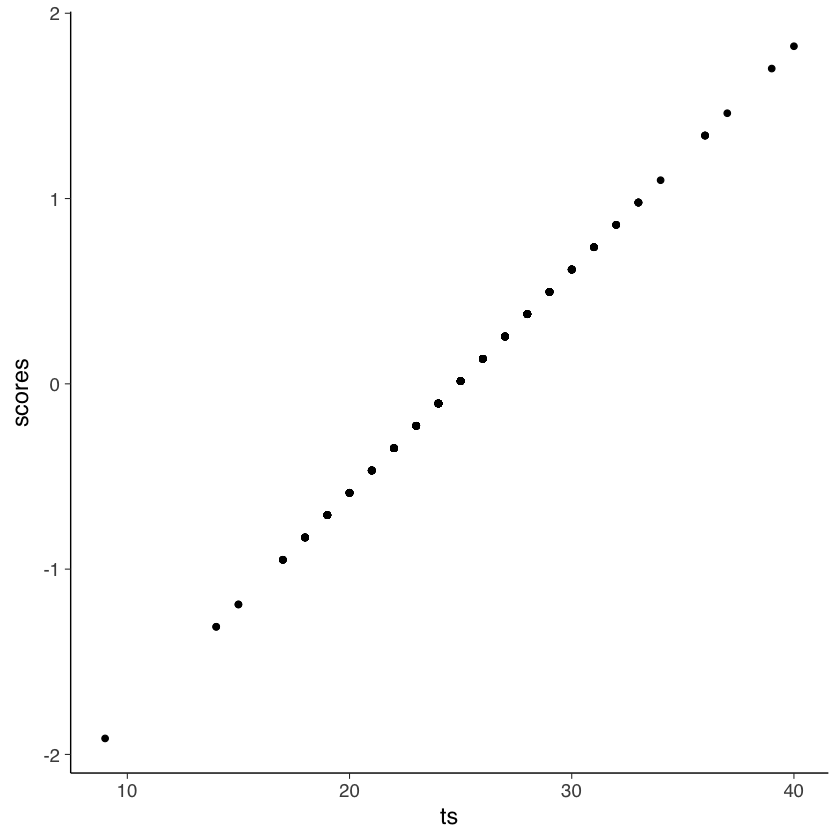

In [10]:
d |> 
  ggplot(aes(x=ts, y=scores)) + 
  geom_point()

Tuttavia, questa conclusione è valida solo se il modello parallelo è giustificato per i dati.  Se esaminiamo l'output di lavaan vediamo che, nel caso presente, questo non è vero.

In [11]:
# report output with fit measures and standardized estimates
out = summary(fit_parallel, fit.measures = TRUE, standardized = TRUE)
print(out)

lavaan 0.6.17 ended normally after 13 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         7
  Number of equality constraints                     5

  Number of observations                           301

Model Test User Model:
                                                      
  Test statistic                               325.899
  Degrees of freedom                                19
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               568.519
  Degrees of freedom                                15
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.446
  Tucker-Lewis Index (TLI)                       0.562

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -26

Dunque, per questi dati, il punteggio totale può ovviamente essere calcolato. Ma *non fornisce una misura adeguata del costrutto*. Dunque, il punteggio totale non dovrebbe essere usato nel caso dei dati ottenuti con questo test.

## Punteggio totale e modello fattoriale congenerico

Gli autori adattano ai dati un modello congenerico.

In [12]:
m_congeneric <- 
'
  #all loadings are uniquely estimated
  f1 =~ NA*X4 + X5 + X6 + X7 + X8 + X9
  #constrain factor variance to 1
  f1 ~~ 1*f1
'

In [13]:
# Fit above model
fit_congeneric <- sem(m_congeneric, data=d)

In [14]:
parameterEstimates(fit_congeneric, standardized = TRUE) %>%
  dplyr::filter(op == "=~") %>%
  dplyr::select(
    "Latent Factor" = lhs,
    Indicator = rhs,
    B = est,
    SE = se,
    Z = z,
    "p-value" = pvalue,
    Beta = std.all
  ) %>%
  knitr::kable(
    digits = 3, booktabs = TRUE, format = "markdown",
    caption = "Factor Loadings"
  )



Table: Factor Loadings

|Latent Factor |Indicator |     B|    SE|      Z| p-value|  Beta|
|:-------------|:---------|-----:|-----:|------:|-------:|-----:|
|f1            |X4        | 0.963| 0.059| 16.274|   0.000| 0.824|
|f1            |X5        | 1.121| 0.067| 16.835|   0.000| 0.846|
|f1            |X6        | 0.894| 0.058| 15.450|   0.000| 0.792|
|f1            |X7        | 0.195| 0.071|  2.767|   0.006| 0.170|
|f1            |X8        | 0.185| 0.063|  2.938|   0.003| 0.180|
|f1            |X9        | 0.278| 0.065|  4.245|   0.000| 0.258|

Si noti che le saturazioni fattoriali sono molto diverse tra loro, suggerendo che il punteggio del costrutto si relaziona in modo diverso con ciascun item e che sarebbe inappropriato stimare il punteggio del costrutto assegnando un peso unitario agli item.

McNeish e Wolf (2020) calcolano poi i punteggi fattoriali del modello congenerico.

In [15]:
scores_cong <- lavPredict(fit_congeneric, method="regression")
d$scores_cong <- as.numeric(scores_cong)

Il grafico seguente mostra la relazione tra i punteggi fattoriali e il punteggio totale.

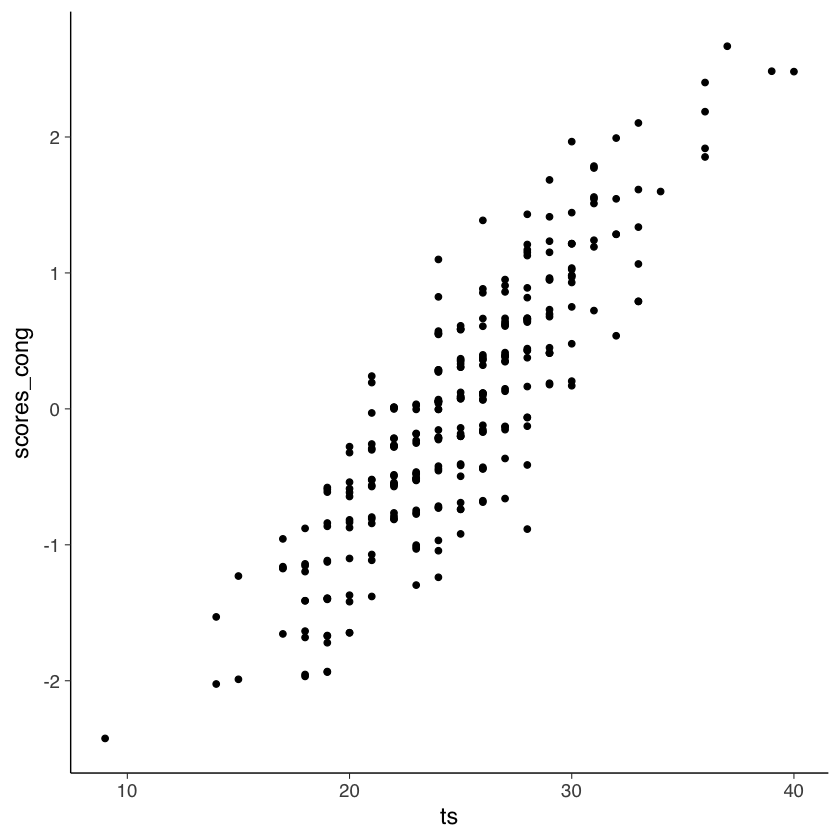

In [16]:
d |> 
  ggplot(aes(x=ts, y=scores_cong)) + 
  geom_point()

Nel caso presente, il coefficiente di determinazione tra punteggio totale e punteggi fattoriali è 0.77.

In [17]:
cor(d$ts, d$scores_cong)^2

[1] 0.765992

Secondo gli autori, ciò significa che due persone con un punteggio totale identico potrebbero avere punteggi di modello congenerico potenzialmente diversi perché hanno raggiunto il loro particolare punteggio totale approvando item diversi. Poiché il modello congenerico assegna pesi diversi agli item, ciascun item contribuisce in modo diverso al punteggio fattoriale del modello congenerico, il che non è vero per il punteggio totale. 

Si noti che, per i dati di Holzinger and Swineford (1939), neppure un modello congenerico ad un fattore si dimostra adeguato.

In [18]:
out = summary(fit_congeneric, fit.measures = TRUE, standardized = TRUE)
print(out)

lavaan 0.6.17 ended normally after 16 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12

  Number of observations                           301

Model Test User Model:
                                                      
  Test statistic                               115.366
  Degrees of freedom                                 9
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               568.519
  Degrees of freedom                                15
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.808
  Tucker-Lewis Index (TLI)                       0.680

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -2575.664
  Loglikelihood unrestricted model (H1)      -25

Se trascuriamo le considerazioni sulla struttura fattoriale e esaminiamo (per esempio) unicamente il coefficiente omega, finiamo per trovare una risposta accettabile, ma sbagliata.

Caricamento dei namespace richiesti: GPArotation



Omega 
Call: omegah(m = m, nfactors = nfactors, fm = fm, key = key, flip = flip, 
    digits = digits, title = title, sl = sl, labels = labels, 
    plot = plot, n.obs = n.obs, rotate = rotate, Phi = Phi, option = option, 
    covar = covar)
Alpha:                 0.72 
G.6:                   0.76 
Omega Hierarchical:    0.55 
Omega H asymptotic:    0.65 
Omega Total            0.84 

Schmid Leiman Factor loadings greater than  0.2 
      g  F1*  F2*   F3*   h2   u2   p2
X4 0.73            0.68 1.00 0.00 0.53
X5 0.96                 0.92 0.08 1.00
X6 0.69            0.22 0.54 0.46 0.90
X7           0.56       0.33 0.67 0.03
X8           0.75       0.59 0.41 0.05
X9 0.22      0.49       0.29 0.71 0.16

With Sums of squares  of:
   g  F1*  F2*  F3* 
2.02 0.00 1.11 0.54 

general/max  1.82   max/min =   257.39
mean percent general =  0.44    with sd =  0.43 and cv of  0.97 
Explained Common Variance of the general factor =  0.55 

The degrees of freedom are 0  and the fit is  0 
The numbe

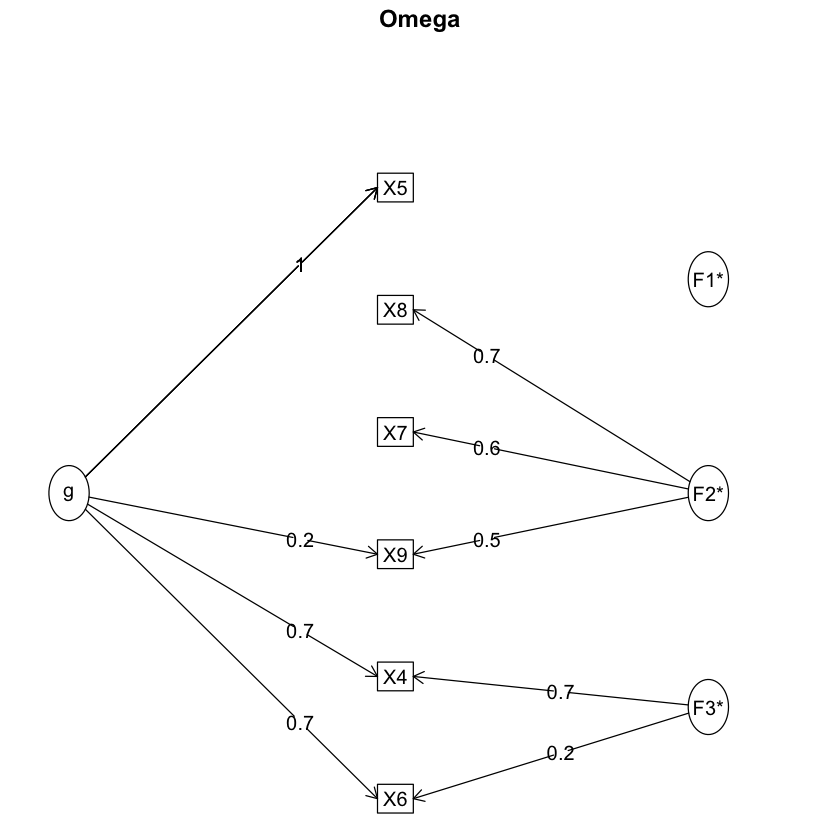

In [19]:
psych::omega(d[, 1:6])

È invece necessario ipotizzare un modello congenerico a due fattori.

In [20]:
m2f_cong <- '
  # all loadings are uniquely estimated on each factor
  f1 =~ NA*X4 + X5 + X6
  f2 =~ NA*X7 + X8 + X9
  
  # constrain factor variancse to 1
  f1 ~~ 1*f1
  f2 ~~ 1*f2
  
  # estimate factor covariance
  f1 ~~ f2
'

In [21]:
# Fit above model
fit_2f_congeneric <- sem(m2f_cong, data=d)

Solo questo modello fornisce un adattamento adeguato ai dati.

In [22]:
out = summary(fit_2f_congeneric, fit.measures = TRUE, standardized = TRUE)
print(out)

lavaan 0.6.17 ended normally after 18 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        13

  Number of observations                           301

Model Test User Model:
                                                      
  Test statistic                                14.736
  Degrees of freedom                                 8
  P-value (Chi-square)                           0.064

Model Test Baseline Model:

  Test statistic                               568.519
  Degrees of freedom                                15
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.988
  Tucker-Lewis Index (TLI)                       0.977

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -2525.349
  Loglikelihood unrestricted model (H1)      -25

Nel contesto di questi dati, l'utilizzo di un modello congenerico non è sufficiente a giustificare l'impiego del punteggio totale, che rappresenta la somma dei punteggi degli item. Questo perché, nel caso specifico, sommando i punteggi di tutti gli item, finiremmo per includere misurazioni di due costrutti distinti.

## Session Info

In [3]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.3.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] modelsummary_1.4.5 ggokabeito_0.1.0   viridis_0.6.5      viridisLite_0.4.2 
 [5] ggpubr_0.6.0       ggExtra_0.10.1     bayesplot_1.11.1   gridExtra_2.3     
 [9] patchwork_1.2.0    semTools_0.5-6     semPlot_1.1.6      lavaan_0.6-17     
[13] psych_2.4.1        scales_1.3.0       markdown_1.12      knitr_1.45        
[17] lubridate_1.9.3    forcats_1.0.0      stringr_1.5.1      dplyr_1.1.4       
[21] purrr_1.0.2        readr_2.1.5        tidyr_1.3.1        tibble_3